### ViT 모델-cifar10

In [4]:
# ViT : Vision Transformer

#   트랜스포머 모델을 이미지 분석에 적용한 모델
#   Conv layer 대신 이미지를 패치 단위로 나누어 입력
# pip install vit_keras
# pip install tensorflow_addons

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from vit_keras import vit, utils
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc

c:\Python3.9.13\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Python3.9.13\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a teste

In [5]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)

train_data = (train_data/255.).astype("float32")
test_data = (test_data/255.).astype("float32")

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

In [8]:
X_train=X_train[::200]
X_valid=X_valid[::200]

y_train=y_train[::200]
y_valid=y_valid[::200]

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((188, 32, 32, 3), (188, 10), (63, 32, 32, 3), (63, 10))

In [10]:
batch_size = 1

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [11]:
# ViT 모델

# 1. 전이학습
input_shape = (32, 32, 3) #cifar10 image size
image_size = 256 # resize 256x256
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)

    # resize image
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs)

    # vit 모델
    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True, include_top=False, pretrained_top=False)    

    # 추론모드로 설정(전이학습)
    base_model.trainable = False

    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tfa.activations.gelu)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    model_final = Model(inputs=inputs, outputs=outputs)

    return model_final

In [12]:
model = build_model()

model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

347502902/347502902 [==============================] - 16s 0us/step


c:\Python3.9.13\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

In [13]:
model.fit(train_generator,
          epochs=2,
          validation_data=(X_valid, y_valid),
         )

gc.collect()

Epoch 1/2
188/188 [==============================] - 46s 148ms/step - loss: 2.3113 - accuracy: 0.0638 - val_loss: 9.4570 - val_accuracy: 0.1270
Epoch 2/2
188/188 [==============================] - 24s 129ms/step - loss: 2.3102 - accuracy: 0.0691 - val_loss: 60.3947 - val_accuracy: 0.1270


724

In [16]:
#2. fine tuning
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#훈련모드로 변경
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizers.SGD(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

In [17]:
tf.keras.backend.clear_session()
gc.collect()

771

In [18]:
history = model.fit(train_generator,
                    epochs=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[plateau, earlystopping]
                   )

Epoch 1/2


188/188 [==============================] - 71s 294ms/step - loss: 2.3003 - accuracy: 0.1064 - val_loss: 326.2777 - val_accuracy: 0.1270 - lr: 0.0010
Epoch 2/2
188/188 [==============================] - ETA: 0s - loss: 2.3003 - accuracy: 0.0904
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
188/188 [==============================] - 52s 274ms/step - loss: 2.3003 - accuracy: 0.0904 - val_loss: 955.7527 - val_accuracy: 0.1270 - lr: 0.0010


In [19]:
accuracy_score(np.argmax(test_label[::150], axis=1), np.argmax(model.predict(test_data[::150]), axis=1))

3/3 [==============================] - 6s 900ms/step


0.11940298507462686

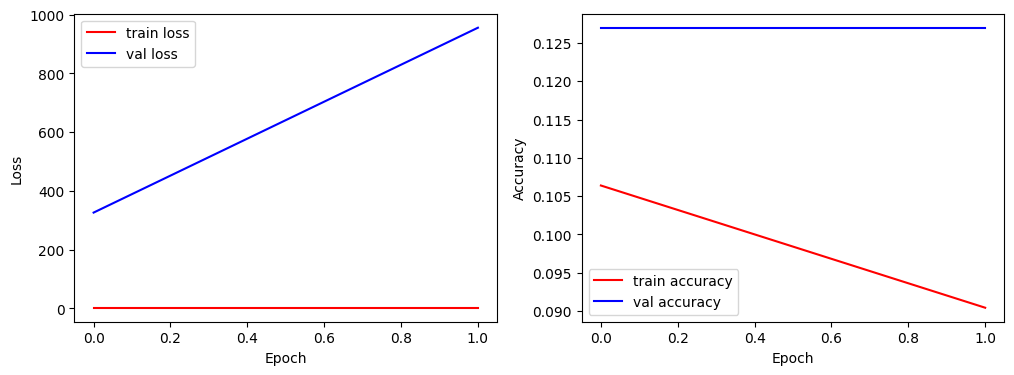

In [20]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

ax[1].legend()